**Import the Required Packages**

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data

In [2]:
labels = ['IC_WITH', 'IC_WITHOUT']
img_size = 200

def load_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_ind = labels.index(label)
        for img in os.listdir(path):
            try:
                img_raw = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_res = cv2.resize(img_raw, (img_size, img_size))
                data.append([img_res, class_ind])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = load_data('/content/drive/MyDrive/data/IC_PINS/train')
test = load_data("/content/drive/MyDrive/data/IC_PINS/test")
val = load_data("/content/drive/MyDrive/data/IC_PINS/val")

<ipython-input-2-654eec8f8a66>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [34]:
# Number of Images in Training Set
train.shape

(100, 2)

In [35]:
#Number of Images in Testing Set
test.shape

(20, 2)

In [36]:
#Number of Images in Validation Set
val.shape

(2, 2)

# HOG feature extraction

In [5]:
from skimage.transform import resize
from skimage.feature import hog

In [6]:
train_hog=train.copy()

for t in train_hog:
  t[0] = resize(t[0], (128,64))

new_boxes=[]
for b in train_hog:
    df = hog(b[0],orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)#, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)
    new_boxes.append(df)
hog_features_train = np.array(new_boxes, 'float64')

In [7]:
test_hog=test.copy()
for t in test_hog:
  t[0] = resize(t[0], (128,64))

new_boxes=[]
for b in test_hog:
    df = hog(b[0],orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)#, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)
    new_boxes.append(df)
hog_features_test = np.array(new_boxes, 'float64')

In [8]:
hog_features_train.shape

(100, 3780)

# LBP Feature extraction

In [9]:
from skimage import feature
def lbp_hist(gray_img, points=24, rad=8):
  #"uniform" is preferred for rotation and grayscale invariance
  lbp = feature.local_binary_pattern(gray_img, P=points, R=rad, method="uniform")
  hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, points+3), range=(0, points+2))
  hist = hist.astype("float")
  hist /= hist.sum()
  return hist

In [10]:
def preprocess_dataset(data, points=24, radius=3):
  new_data = []
  for row in data:
    new_data.append(lbp_hist(gray_img=row[0], points=points, rad=radius))
  
  return np.array(new_data), data[:, 1].astype('int')

In [11]:
X_train, y_train = preprocess_dataset(train)
X_val, y_val = preprocess_dataset(val)
X_test, y_test = preprocess_dataset(test)

In [12]:
X_test, y_test = np.concatenate((X_test, X_val), axis=0), np.concatenate((y_test, y_val), axis=0)
np.random.seed(42)
temp = list(zip(X_test, y_test))
np.random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test, y_test = np.array(X_test), np.array(y_test)
for i in range(X_test.shape[0]):
  X_test[i] = X_test[i].reshape(1, -1)

# SVM+HOG

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [14]:
clf = SVC()

In [15]:
labels_train=[]
for t in train_hog:
  labels_train.append(t[1])

labels_test=[]
for t in test_hog:
  labels_test.append(t[1])

In [16]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(SVC(kernel="linear"), param_grid, cv=5, verbose=20, n_jobs=-1)

grid_search.fit(hog_features_train, labels_train)
print("Accuracy on test set: {:.2f}".format(grid_search.score(hog_features_test, labels_test)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Accuracy on test set: 1.00


In [17]:
grid_search.best_params_

{'C': 0.1, 'gamma': 0.001}

In [18]:
best_hog_svc = grid_search.best_estimator_
labels_hog_pred = best_hog_svc.predict(hog_features_test)
print(accuracy_score(labels_test,labels_hog_pred))

1.0


In [90]:
predicted_label = best_hog_svc.predict(hog_features_test)

#print the predicted label of the image
print("Predicted label:", labels_test)

Predicted label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [85]:
result = pd.DataFrame({'original' : labels_test,'predicted' : labels_hog_pred})

In [86]:
result

,original,predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [21]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, labels_hog_pred, target_names=['IC_WITH', 'IC_WITHOUT']))

              precision    recall  f1-score   support

     IC_WITH       1.00      1.00      1.00        10
  IC_WITHOUT       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



<Figure size 432x288 with 0 Axes>

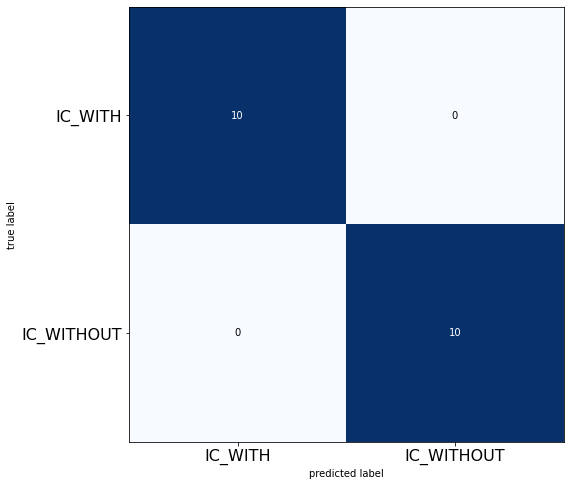

In [22]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Get the confusion matrix
cm  = confusion_matrix(labels_test, labels_hog_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['IC_WITH', 'IC_WITHOUT'], fontsize=16)
plt.yticks(range(2), ['IC_WITH', 'IC_WITHOUT'], fontsize=16)
plt.show()

In [87]:
for i in range(len(labels_test)):
  if labels_test[i] == 0 and labels_hog_pred[i]==1:
    print(i)

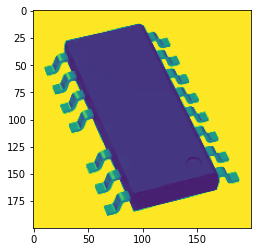

In [24]:
plt.imshow(train[17][0])
plt.show()

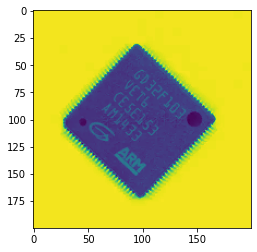

In [25]:
plt.imshow(test[10][0])
plt.show()

# SVM+LBP

In [26]:
C_vals = np.logspace(start=-2, stop=4, num=15, endpoint=True, dtype=float)
params = {'C': C_vals,
           'gamma': np.logspace(start=-5, stop=5, num=15)}
svc = SVC(kernel='rbf', random_state=42, verbose=True)
grid_search_lbp = GridSearchCV(svc, param_grid=params, n_jobs=-1, cv=5, verbose=2)

In [27]:
grid_search_lbp.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[LibSVM]

GridSearchCV(cv=5, estimator=SVC(random_state=42, verbose=True), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.68269580e-02, 7.19685673e-02, 1.93069773e-01,
       5.17947468e-01, 1.38949549e+00, 3.72759372e+00, 1.00000000e+01,
       2.68269580e+01, 7.19685673e+01, 1.93069773e+02, 5.17947468e+02,
       1.38949549e+03, 3.72759372e+03, 1.00000000e+04]),
                         'gamma': array([1.00000000e-05, 5.17947468e-05, 2.68269580e-04, 1.38949549e-03,
       7.19685673e-03, 3.72759372e-02, 1.93069773e-01, 1.00000000e+00,
       5.17947468e+00, 2.68269580e+01, 1.38949549e+02, 7.19685673e+02,
       3.72759372e+03, 1.93069773e+04, 1.00000000e+05])},
             verbose=2)

In [28]:
grid_search_lbp.best_params_

{'C': 193.06977288832496, 'gamma': 26.826957952797272}

In [29]:
y_test_pred = grid_search_lbp.best_estimator_.predict(X=X_test)
print(accuracy_score(y_test, y_test_pred))
print(grid_search_lbp.best_estimator_.score(X=X_test, y=y_test))

0.9090909090909091
0.9090909090909091


In [30]:
result2 = pd.DataFrame({'original' : y_test,'predicted' : y_test_pred})

In [31]:
result2

,original,predicted
0,0,0
1,1,1
2,0,0
3,0,0
4,1,0
5,0,0
6,0,0
7,1,0
8,0,0
9,0,0


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred, target_names=['IC_WITH', 'IC_WITHOUT']))

              precision    recall  f1-score   support

     IC_WITH       0.85      1.00      0.92        11
  IC_WITHOUT       1.00      0.82      0.90        11

    accuracy                           0.91        22
   macro avg       0.92      0.91      0.91        22
weighted avg       0.92      0.91      0.91        22



<Figure size 432x288 with 0 Axes>

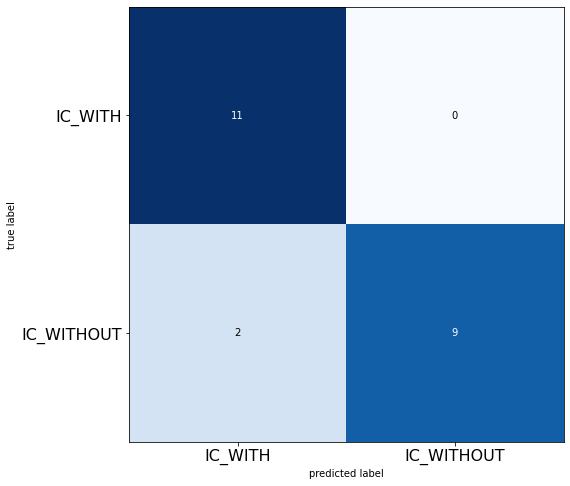

In [33]:
# Get the confusion matrix
cm  = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['IC_WITH', 'IC_WITHOUT'], fontsize=16)
plt.yticks(range(2), ['IC_WITH', 'IC_WITHOUT'], fontsize=16)
plt.show()

In [89]:
predicted_label = grid_search_lbp.best_estimator_.predict(X=X_test)

#print the predicted label of the image
print("Predicted label:", y_test)

Predicted label: [0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0]


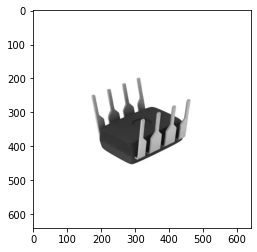

In [79]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
img = imread('/content/drive/MyDrive/data/IC_PINS/test/IC_WITH/IC_WITH (1).png')
plt.imshow(img)
plt.show()